In [1]:
import json

with open('kaggle.json') as f:
    kaggle_dictionary = json.load(f)

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = kaggle_dictionary["username"]
os.environ['KAGGLE_KEY'] = kaggle_dictionary["key"]

In [3]:
!kaggle datasets download -d adityajn105/flickr8k #https://www.kaggle.com/datasets/adityajn105/flickr30k #you can also use flicker 30k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.04G/1.04G [00:47<00:00, 24.5MB/s]
100% 1.04G/1.04G [00:47<00:00, 23.2MB/s]


In [4]:
!unzip -q flickr8k.zip

In [5]:
print(len(os.listdir("Images"))) #Number of images in the dataset

8091


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt
import os

In [7]:
from transformers import GPT2Tokenizer, GPT2Model,GPT2LMHeadModel,AutoModelForCausalLM
from transformers import CLIPProcessor, CLIPVisionModelWithProjection

model_file_name = "openai-community/gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_file_name,return_tensors='pt',pad_token="<|endoftext|>")# we must add pad token
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

In [9]:
data = pd.read_csv("captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [10]:
len_list = []
token_list = []
for i in tqdm(range(len(data))):
  caption = data.iloc[i]["caption"]

  tokens = tokenizer(caption)
  token_list += tokens["input_ids"]
  len_list.append(len(tokens["input_ids"]))


100%|██████████| 40455/40455 [00:08<00:00, 4711.82it/s]


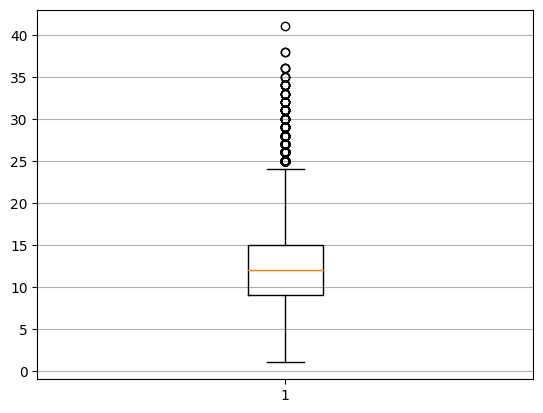

In [11]:
plt.boxplot(len_list)
plt.grid(axis="y")
plt.show()

In [12]:
print("Max len ",max(len_list))
print("Min len ",min(len_list))

num_tokens = len(np.unique(token_list))

print("Num unique tokens ",num_tokens)

Max len  41
Min len  1
Num unique tokens  8517


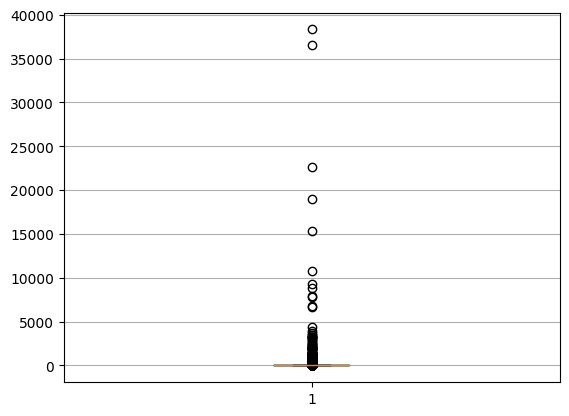

In [13]:
_,counts= np.unique(token_list,return_counts=True)
plt.boxplot(counts)
plt.grid(axis="y")
plt.show()

In [28]:
num_unique = 0
for i in range(1,len(data)):
  caption_current = data.iloc[i]["image"]
  caption_prev = data.iloc[i-1]["image"]

  if caption_current != caption_prev:
    num_unique += 1

  if num_unique >= 7000: #find index of where first 7000 unique images end
    print(i)
    break

35000


In [41]:
class Image_dataset(Dataset):
    def __init__(self, root_dir, data_frame, transform):

        self.root_dir = root_dir
        self.data = data_frame
        self.transform = transform

        for i in range(len(self.data)):
            #we add bos and eos tokens to start and end
            self.data[i][1] = tokenizer.bos_token + self.data[i][1] + tokenizer.eos_token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name, caption = self.data[idx]
        try:
          img = Image.open(os.path.join(self.root_dir,image_name))
        except Exception as e:
          print(e)

        img = self.transform(text=None,images=img,return_tensors="pt")["pixel_values"]

        return img, caption

data = pd.read_csv("captions.txt")

train_set = Image_dataset(
    root_dir = "Images",
    data_frame = data[:34999].values, #first 7000 images are train
    transform=processor,
)

val_set = Image_dataset(
    root_dir = "Images",
    data_frame = data[35000:].values,
    transform=processor,
)


def customBatchBuilder(samples):
    imgs, captions = zip(*samples)

    #We need to pad sequences so that each batch has same length
    tokenized_inp = tokenizer(captions,padding='longest', max_length=80,return_tensors="pt") #max batch olmalı
    imgs = torch.concat(imgs)

    text = tokenized_inp["input_ids"]
    mask = tokenized_inp["attention_mask"]

    return imgs, text , mask

In [42]:
train_set_size = len(train_set)
print("Train set size:", train_set_size)
val_set_size = len(val_set)
print("Val set size:", val_set_size)



batch_size = 64

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=customBatchBuilder)

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=customBatchBuilder)



inputs, text, mask = next(iter(train_loader))

print("Sample input shape ", inputs.shape)
print("Sample text shape", text.shape)

device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)  # checks if there is gpu available
print("Sample text decoded",tokenizer.decode(text[0]))

Train set size: 34999
Val set size: 5455
Sample input shape  torch.Size([64, 3, 224, 224])
Sample text shape torch.Size([64, 26])
Sample text decoded <|endoftext|>A brown dog is standing in the water.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


In [43]:
d_model = 768
vocab_size = tokenizer.vocab_size

In [44]:
import torch.nn.functional as F
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import dataset
import math
class Net(nn.Module):
    def __init__(self,d_model,vocab_size):
        super(Net,self).__init__()

        self.d_model = d_model
        self.vocab_size = vocab_size

        self.image_encoder = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")

        self.image_out = nn.Sequential(
            nn.Linear(512, self.d_model), nn.ReLU(), nn.Linear(self.d_model, self.d_model)
        )

        self.text_decoder = GPT2LMHeadModel.from_pretrained(model_file_name,add_cross_attention=True)
        self.text_decoder.resize_token_embeddings(self.vocab_size)

    def forward(self, image,text,attention_mask):

        batch_size = image.size(0)

        image_vec = self.image_encoder(image).image_embeds

        image_vec = self.image_out(image_vec.view(batch_size,512))
        image_vec = image_vec.unsqueeze(1)

        output = self.text_decoder(text,attention_mask=attention_mask,encoder_hidden_states=image_vec)[0]#.last_hidden_state

        return output
model = Net(d_model,tokenizer.vocab_size)
model.to(device)

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weigh

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Net(
  (image_encoder): CLIPVisionModelWithProjection(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (position_embedding): Embedding(50, 768)
      )
      (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
       

In [45]:
inputs, text, attention_mask = next(iter(train_loader))

In [46]:
inputs = inputs.to(device)
text = text.to(device)
attention_mask = attention_mask.to(device)

In [47]:
out = model(inputs,text,attention_mask)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [48]:
print(out.shape)

torch.Size([64, 26, 50257])


In [49]:
def train_model(
    model, criterion, optimizer, num_epochs=10, checkp_epoch=0, scheduler=None
):
    since = time.time()

    if log is True:
        my_file = open(plot_file, "a")

    pbar = tqdm(range(checkp_epoch, num_epochs))
    for epoch in pbar:

        model.train()

        running_loss = 0.0

        for sample in train_loader:
            inputs, texts, attention_mask = sample
            batch_size = inputs.size(0)
            inputs = inputs.to(device)
            texts = texts.to(device)
            attention_mask = attention_mask.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):

                out = model(inputs,texts,attention_mask)

                texts = texts[:,1:] #remove bos token from target
                out = out[:,:-1,:] # remove last prediction

                loss = criterion(out.reshape(-1,out.size(-1)), texts.reshape(-1))
                loss.backward()
                optimizer.step()
                if scheduler != None:
                    scheduler.step()

            running_loss += loss.item() * batch_size

        train_loss = running_loss / train_set_size

        model.eval()

        running_loss = 0.0

        with torch.no_grad():
            for sample in val_loader:
                inputs, texts, attention_mask = sample
                batch_size = inputs.size(0)
                inputs = inputs.to(device)
                texts = texts.to(device)
                attention_mask = attention_mask.to(device)


                out = model(inputs,texts,attention_mask)

                texts = texts[:,1:]
                out = out[:,:-1,:]
                loss = criterion(out.reshape(-1,out.size(-1)), texts.reshape(-1))


                # statistics
                running_loss += loss.item() * batch_size

        val_loss = running_loss / val_set_size
        if log is True:
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": loss,
                },
                checkpoint_file,
            )

            data = {
                "epoch": epoch,
                "train_loss": train_loss,
                "val_loss": val_loss,
            }
            df = pd.DataFrame(data, index=[0])
            df.to_csv(my_file, header=False, index=False)


        pbar.set_description(
            "train loss {:.4} val loss {:.4}".format(train_loss, val_loss)
        )
    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )

    return model

In [50]:
log = True
model = Net(d_model,tokenizer.vocab_size)
device = "cuda"
model.to(device)
model.image_encoder.requires_grad_(False)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weigh

In [51]:
criterion = nn.CrossEntropyLoss()
now = datetime.now()

checkpoint_file = "image_captioning" + now.strftime("%d_%m_%Y_%H:%M:%S") + ".pt"
plot_file = "image_captioning" + now.strftime("%d_%m_%Y_%H:%M:%S") + ".csv"


num_epochs = 5


model = train_model(
    model, criterion, optimizer, num_epochs=num_epochs, scheduler=None
)

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
train loss 0.9401 val loss 1.207: 100%|██████████| 5/5 [35:05<00:00, 421.15s/it]

Training complete in 35m 6s


In [52]:
torch.save(model.state_dict(),"gpt_caption_clip.pt")

In [56]:
inputs, text_orig, _ = next(iter(val_loader))
inputs = inputs.to(device)
attention_mask = torch.zeros(1,30).to(device)
text = torch.Tensor([tokenizer.eos_token_id]).repeat(30).unsqueeze(0).to(device)


index = 0

for i in tqdm(range(29)):
  attention_mask[:,i] = 1

  out = model(inputs[index,...].unsqueeze(0),text.long(),attention_mask)

  _, indices = torch.max(out[:,i,:],1)
  text[:,i+1] = indices

100%|██████████| 29/29 [00:00<00:00, 30.72it/s]


Predicted
<|endoftext|>A boy jumps into a pool.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Original
<|endoftext|>A boy wearing red and blue swim trunks jumping headfirst into a swimming pool.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


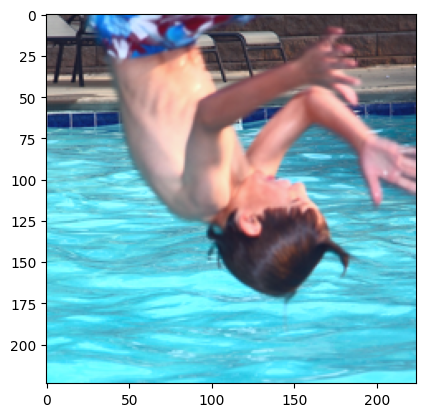

In [57]:
img = inputs[index]

img = img.permute(1,2,0)
img = torch.clamp((img+2)/4,0,1).cpu().numpy()
#img = (img+0.5)

plt.imshow(img)
print("Predicted")
print(tokenizer.decode(text[0]))
print("Original")
print(tokenizer.decode(text_orig[index]))